# Graphical Analysis of GitHub Repositories and Contributors

In this notebook, we programatically view the connections between open source projects, determine project clusters, and map out technology ecosystems. We explore the Augur GitHub data to view relationships between open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd
import collections
from operator import itemgetter

import sqlalchemy as salc
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

with open("../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Retrieve Available Repositories for OpenShift and Kubernetes

In [3]:
# Subset repositories based on a category
# Selecting repositories that fall under the Containers org on Github

repos_openshift = ['https://github.com/openshift/origin',
                  'https://github.com/openshift/source-to-image',
                  'https://github.com/openshift/openshift-ansible',
                  'https://github.com/openshift/osin',
                  'https://github.com/openshift/installer']

repos_kubernetes = ['https://github.com/kubernetes/kubernetes',
                   'https://github.com/kubernetes/minikube',
                   'https://github.com/kubernetes/kops',
                   'https://github.com/kubernetes/ingress-nginx',
                   'https://github.com/kubernetes/dashboard']

repos = repos_openshift + repos_kubernetes
repo_set = []
repo_name_set = []

In [4]:
for repo_git in repos:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id,
                    b.repo_name
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_git = \'{repo_git}\'
        """)

    t = engine.execute(repo_query)
    results = t.mappings().all()[0]
    repo_id = results['repo_id']
    repo_name = results['repo_name']
    repo_set.append(repo_id)
    repo_name_set.append(repo_name)
print(repo_set)
print(repo_name_set)

[32413, 32390, 32537, 32408, 32010, 27835, 27850, 27833, 27805, 27825]
['origin', 'source-to-image', 'openshift-ansible', 'osin', 'installer', 'kubernetes', 'minikube', 'kops', 'ingress-nginx', 'dashboard']


### Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [5]:
issue_contrib = pd.DataFrame()
for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                i.cntrb_id,
                i.issue_id
                FROM
                repo r, issues i
                 WHERE
                i.repo_id = \'{repo_id}\' AND
                i.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    issue_contrib = pd.concat([issue_contrib, df_current_repo])

issue_contrib = issue_contrib.reset_index()
issue_contrib.drop("index", axis=1, inplace=True)
issue_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'issue_id']
display(issue_contrib)
issue_contrib.dtypes

repo_id                                 repo_git   cntrb_id  issue_id
0         32413      https://github.com/openshift/origin  1610250.0   2065265
1         32413      https://github.com/openshift/origin  1610250.0   2065315
2         32413      https://github.com/openshift/origin  1610250.0   2598045
3         32413      https://github.com/openshift/origin  1610250.0   2598047
4         32413      https://github.com/openshift/origin  1610250.0   2591536
...         ...                                      ...        ...       ...
101830    27825  https://github.com/kubernetes/dashboard        NaN   2513906
101831    27825  https://github.com/kubernetes/dashboard        NaN   2513907
101832    27825  https://github.com/kubernetes/dashboard        NaN   2513908
101833    27825  https://github.com/kubernetes/dashboard        NaN   2513909
101834    27825  https://github.com/kubernetes/dashboard        NaN   2513910

[101835 rows x 4 columns]

repo_id       int64
repo_git     object
cntrb_id    float64
issue_id      int64
dtype: object

### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [6]:
pr_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                prm.cntrb_id,
                prm.pull_request_id
                FROM
                repo r, pull_request_meta prm
                WHERE
                prm.repo_id = \'{repo_id}\' AND
                prm.repo_id = r.repo_id
                LIMIT 50000
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    pr_contrib = pd.concat([pr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
pr_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'pull_request_id']
display(pr_contrib)
pr_contrib.dtypes

repo_id                                 repo_git  cntrb_id  \
0         32413      https://github.com/openshift/origin     57847   
1         32413      https://github.com/openshift/origin   2206298   
2         32413      https://github.com/openshift/origin   2204295   
3         32413      https://github.com/openshift/origin    127041   
4         32413      https://github.com/openshift/origin   2204295   
...         ...                                      ...       ...   
150875    27825  https://github.com/kubernetes/dashboard   2206573   
150876    27825  https://github.com/kubernetes/dashboard   2223236   
150877    27825  https://github.com/kubernetes/dashboard   2206573   
150878    27825  https://github.com/kubernetes/dashboard   2206573   
150879    27825  https://github.com/kubernetes/dashboard   2206573   

        pull_request_id  
0               1467804  
1               1467805  
2               1467805  
3               1467806  
4               1467806  
...                 ...  
150875          1308640  
150876          1308653  
150877          1308639  
150878          1308639  
150879          1308653  

[150880 rows x 4 columns]

repo_id             int64
repo_git           object
cntrb_id            int64
pull_request_id     int64
dtype: object

### Retrieve PR Reviewers

We will now fetch all the PR Reviewers for various repositories.

In [7]:
prr_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                prr.cntrb_id,
                prr.pull_request_id
                FROM
                repo r, pull_request_reviews prr
                WHERE
                prr.repo_id = \'{repo_id}\' AND
                prr.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    prr_contrib = pd.concat([prr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
prr_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'pull_request_id']
display(prr_contrib)
prr_contrib.dtypes

Empty DataFrame
Columns: [repo_id, repo_git, cntrb_id, pull_request_id]
Index: []

repo_id            object
repo_git           object
cntrb_id           object
pull_request_id    object
dtype: object

### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [8]:
commit_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                ca.cntrb_id,
                c.cmt_id
                FROM
                repo r, commits c, contributors_aliases ca
                WHERE
                c.repo_id = \'{repo_id}\' AND
                c.repo_id = r.repo_id and
                c.cmt_committer_email = ca.alias_email
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    commit_contrib = pd.concat([commit_contrib, df_current_repo])

commit_contrib = commit_contrib.reset_index()
commit_contrib.drop("index", axis=1, inplace=True)
commit_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'cmt_id']
display(commit_contrib)
commit_contrib.dtypes

repo_id                                 repo_git  cntrb_id     cmt_id
0          32413      https://github.com/openshift/origin   2204329  115065931
1          32413      https://github.com/openshift/origin   2204329  115066504
2          32413      https://github.com/openshift/origin     57925  114969699
3          32413      https://github.com/openshift/origin     57925  114969725
4          32413      https://github.com/openshift/origin     57925  114969755
...          ...                                      ...       ...        ...
1786255    27825  https://github.com/kubernetes/dashboard   2252911   11228806
1786256    27825  https://github.com/kubernetes/dashboard   2252911   11270464
1786257    27825  https://github.com/kubernetes/dashboard   2252911   11270465
1786258    27825  https://github.com/kubernetes/dashboard   2252911   11270466
1786259    27825  https://github.com/kubernetes/dashboard   2252911   11270467

[1786260 rows x 4 columns]

repo_id      int64
repo_git    object
cntrb_id     int64
cmt_id       int64
dtype: object

In [9]:
openshift_repos_ids = commit_contrib[commit_contrib['repo_git'].isin(repos_openshift)]['repo_id'].unique()
kubernetes_repos_ids = commit_contrib[commit_contrib['repo_git'].isin(repos_kubernetes)]['repo_id'].unique()

In [10]:
openshift_repos_ids

array([32413, 32390, 32537, 32408, 32010])

In [11]:
kubernetes_repos_ids

array([27835, 27850, 27833, 27805, 27825])

## Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributor Graph

In [12]:
df_commit = commit_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
df_commit.head()

cntrb_id  25462    25483    25489    25512    25515    25551    25552    \
repo_id                                                                   
27805           0        0        0        0        0        0        0   
27825           0        0        0        0        0        0        0   
27833           0        0        0        0        0        0        0   
27835           0        0        0        0        6        2        4   
27850           0        0        0        0        0        0        1   

cntrb_id  25566    25571    25667    ...  2557282  2557283  2557284  2557285  \
repo_id                              ...                                       
27805           0        0        0  ...        0        0        0        0   
27825           0        0        0  ...        0        0        0        0   
27833           0        0        0  ...        0        0        0        0   
27835         111      104     1751  ...        1        2       23        1   
27850           0        0        0  ...        0        0        0        0   

cntrb_id  2557286  2557287  2557288  2557289  2557290  2557291  
repo_id                                                         
27805           0        0        0        0        0        0  
27825           0        0        0        0        0        0  
27833           0        0        0        0        0        0  
27835           1       46        1        1        1       10  
27850           0        0        0        0        0        0  

[5 rows x 2283 columns]

In the above dataframe, each row represents a repository ID and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a a number x means that the contributor has made x number of commits to the repository.

In [13]:
df_commit = df_commit.reset_index()

In [14]:
df_commit.head()

cntrb_id  repo_id  25462  25483  25489  25512  25515  25551  25552  25566  \
0           27805      0      0      0      0      0      0      0      0   
1           27825      0      0      0      0      0      0      0      0   
2           27833      0      0      0      0      0      0      0      0   
3           27835      0      0      0      0      6      2      4    111   
4           27850      0      0      0      0      0      0      1      0   

cntrb_id  25571  ...  2557282  2557283  2557284  2557285  2557286  2557287  \
0             0  ...        0        0        0        0        0        0   
1             0  ...        0        0        0        0        0        0   
2             0  ...        0        0        0        0        0        0   
3           104  ...        1        2       23        1        1       46   
4             0  ...        0        0        0        0        0        0   

cntrb_id  2557288  2557289  2557290  2557291  
0               0        0        0        0  
1               0        0        0        0  
2               0        0        0        0  
3               1        1        1       10  
4               0        0        0        0  

[5 rows x 2284 columns]

In [15]:
df_melted_commit = df_commit.melt(
    ['repo_id'],
    var_name = 'cntrb_id',value_name='number')

In [16]:
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit.head()

repo_id cntrb_id  number
9     32537    25462       1
18    32413    25483       6
19    32537    25483       8
28    32413    25489       2
29    32537    25489      70

In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

In [17]:
G = nx.from_pandas_edgelist(df_melted_commit, 
                            source='repo_id',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiDiGraph())

In [18]:
nodes = G.nodes()

In [19]:
Repo_id = df_melted_commit['repo_id'].to_list()
contributor_id = df_melted_commit['cntrb_id'].to_list()

In [20]:
colors = []
for n in nodes:
    if n in kubernetes_repos_ids:
        colors.append('blue')
    elif n in openshift_repos_ids:
        colors.append('green')
    else:
        colors.append('yellow')
    

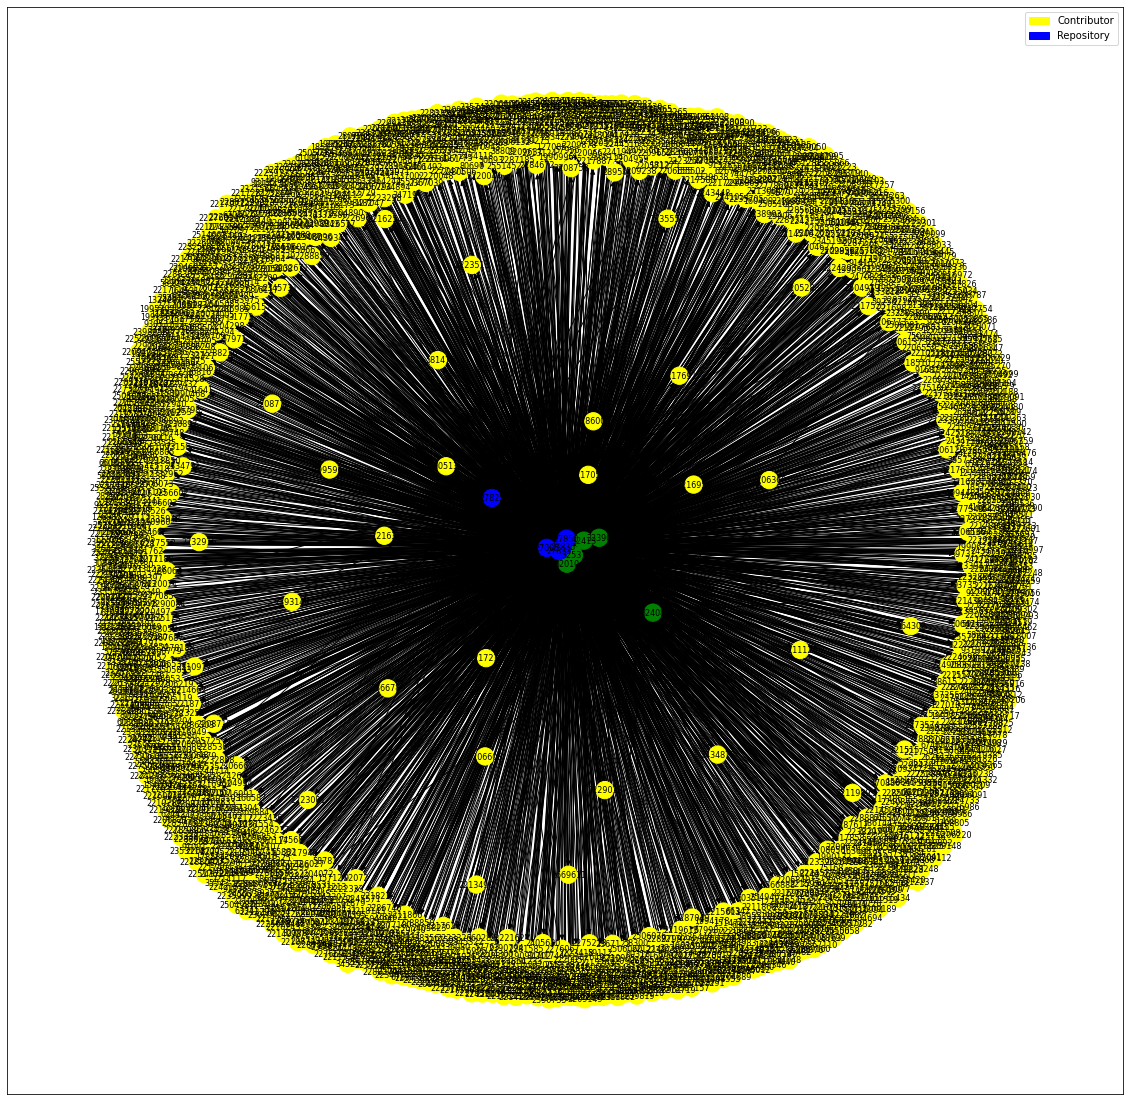

In [21]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Repository')
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

### Use PageRank and Betweenness Centrality to subset nodes

In [22]:
#Convert G to directed graph
H = nx.DiGraph(G)

In [111]:
nodes = H.nodes()
colors = []
for n in nodes:
    if n in kubernetes_repos_ids:
        colors.append('blue')
    elif n in openshift_repos_ids:
        colors.append('green')
    else:
        colors.append('yellow')

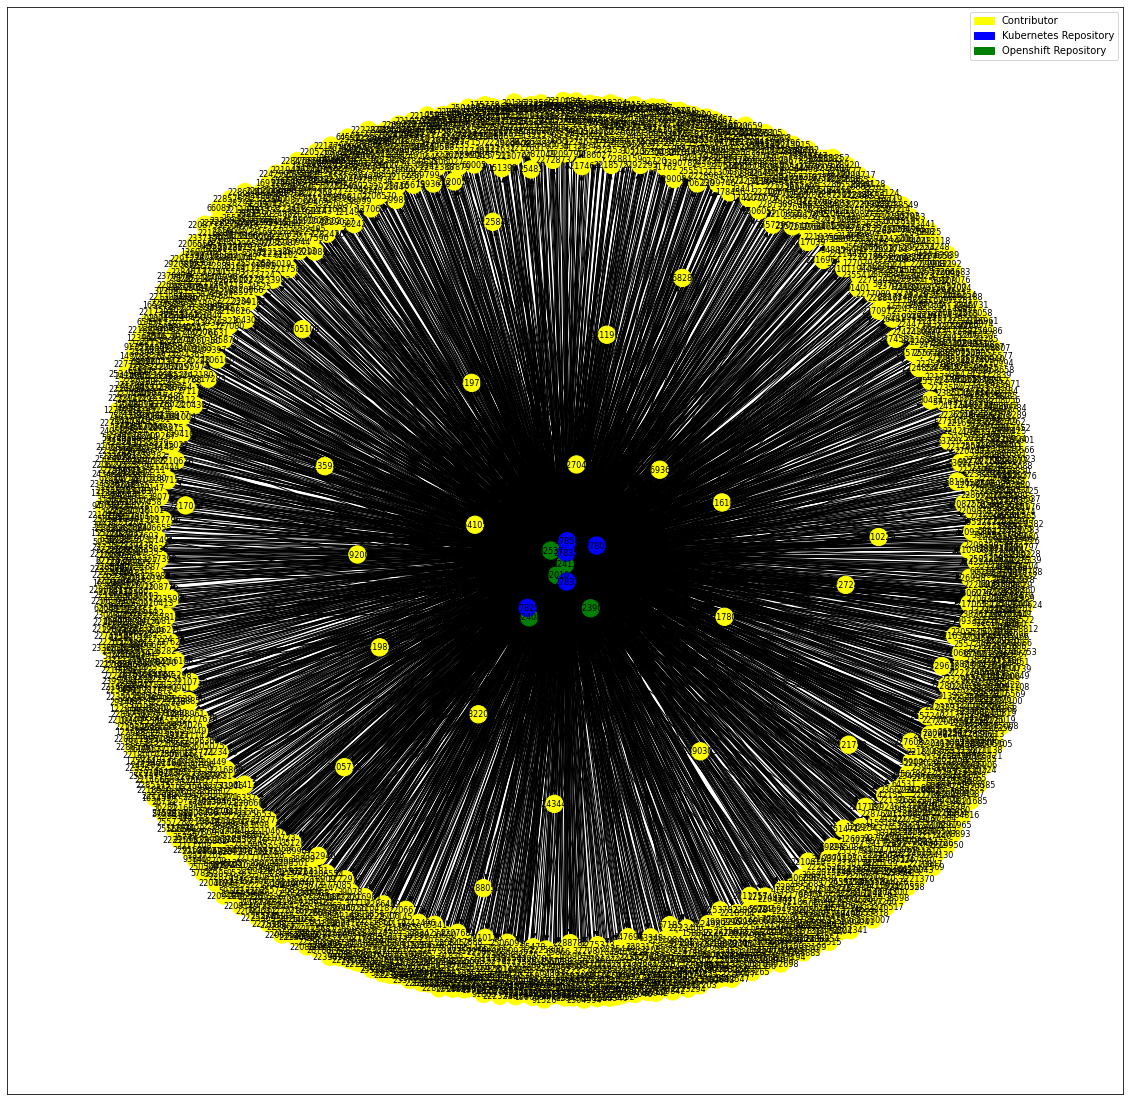

In [122]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Kubernetes Repository')
green_patch = mpatches.Patch(color='green', label='Openshift Repository')
ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(H, node_color=colors, font_size=8, ax=ax)

### Page Rank

In [130]:
pageranks = nx.pagerank(H, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

The first input parameter of the method, H, is the NetworkX graph. Undirected graphs will be converted to a directed graph with two directed edges for each undirected edge. The second parameter, alpha, is the damping parameter for PageRank and the default value is 0.85. The fourth parameter, max_iter, is the Maximum number of iterations. The seventh parameter, weight, represents the edge attribute that should be used as the edge weight. If it’s not specified, the weight of all edges will be 1.

In [123]:
topnodes = dict(sorted(pageranks.items(), key = itemgetter(1), reverse = False)[:200])

We want to give higher priority to outgoing nodes. So we take 200 nodes with lowest pagerank

In [124]:
key = topnodes.keys()

In [125]:
subgraph = nx.subgraph(H, key)

In [126]:
subgraph

In [127]:
nodes = subgraph.nodes()
colors = []
for n in nodes:
    if n in kubernetes_repos_ids:
        colors.append('blue')
    elif n in openshift_repos_ids:
        colors.append('green')
    else:
        colors.append('yellow')

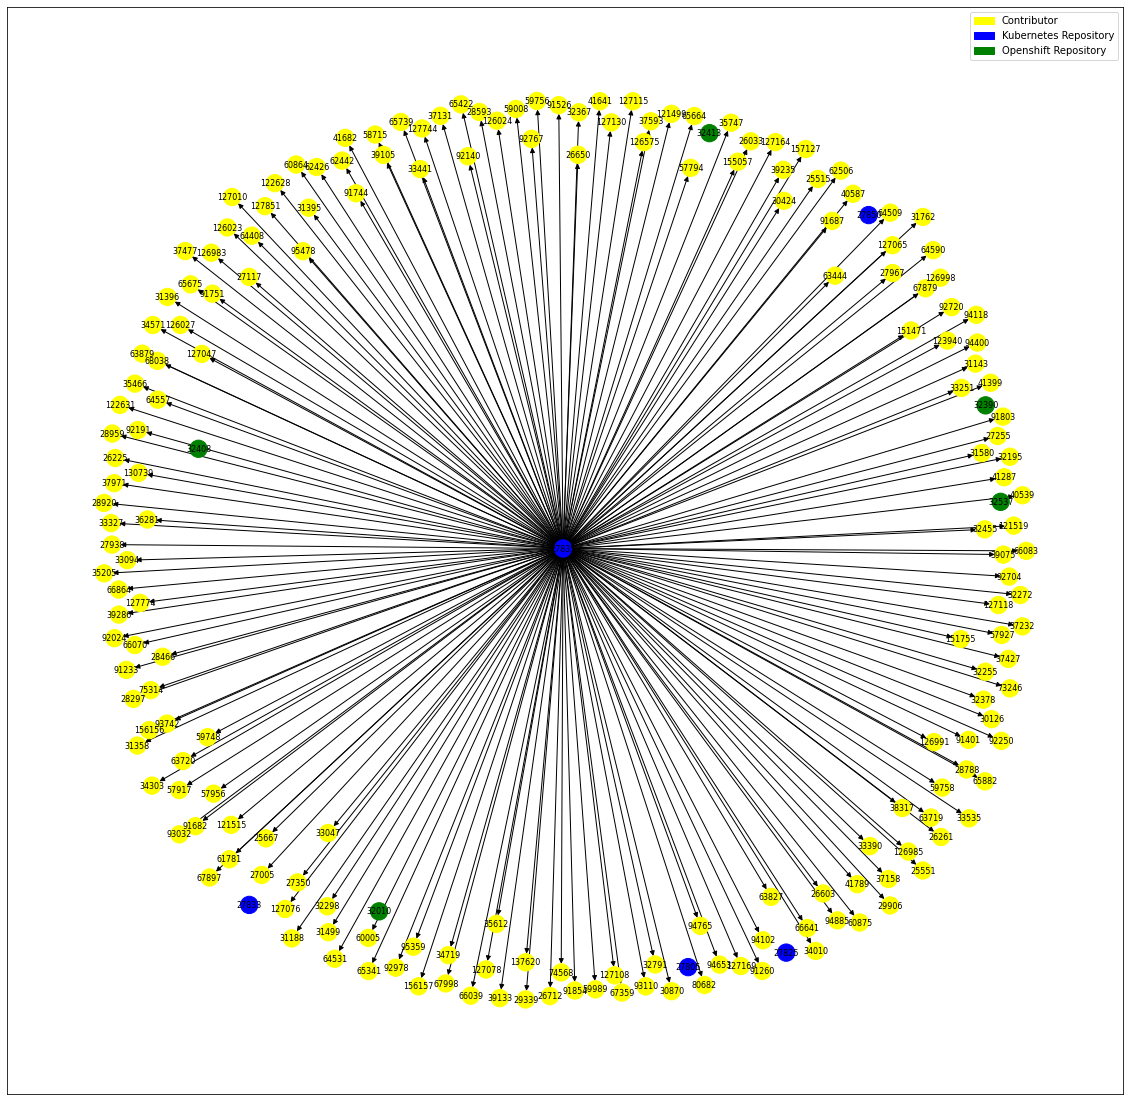

In [128]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Kubernetes Repository')
green_patch = mpatches.Patch(color='green', label='Openshift Repository')
ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(subgraph, node_color=colors, font_size=8, ax=ax)

### Betweenness centrality

In [140]:
centrality = nx.betweenness_centrality(H)

In [141]:
centrality

{32537: 0.0,
 25462: 0.0,
 32413: 0.0,
 25483: 0.0,
 25489: 0.0,
 32010: 0.0,
 25512: 0.0,
 27835: 0.0,
 25515: 0.0,
 25551: 0.0,
 25552: 0.0,
 27850: 0.0,
 25566: 0.0,
 25571: 0.0,
 25667: 0.0,
 26033: 0.0,
 27805: 0.0,
 26127: 0.0,
 26225: 0.0,
 26248: 0.0,
 26261: 0.0,
 26394: 0.0,
 27833: 0.0,
 26481: 0.0,
 26603: 0.0,
 26624: 0.0,
 26650: 0.0,
 26712: 0.0,
 27005: 0.0,
 27117: 0.0,
 27133: 0.0,
 27143: 0.0,
 27255: 0.0,
 27291: 0.0,
 27337: 0.0,
 27350: 0.0,
 27802: 0.0,
 27916: 0.0,
 27938: 0.0,
 27967: 0.0,
 28077: 0.0,
 28282: 0.0,
 28297: 0.0,
 28316: 0.0,
 28466: 0.0,
 28593: 0.0,
 28698: 0.0,
 28716: 0.0,
 32408: 0.0,
 28751: 0.0,
 28788: 0.0,
 28920: 0.0,
 28959: 0.0,
 29148: 0.0,
 29242: 0.0,
 29339: 0.0,
 29451: 0.0,
 29845: 0.0,
 29880: 0.0,
 29906: 0.0,
 30126: 0.0,
 27825: 0.0,
 30149: 0.0,
 30353: 0.0,
 30424: 0.0,
 30513: 0.0,
 30693: 0.0,
 30774: 0.0,
 30845: 0.0,
 30870: 0.0,
 31143: 0.0,
 31188: 0.0,
 31358: 0.0,
 31395: 0.0,
 31396: 0.0,
 31499: 0.0,
 31576: 0.0,

For this case all are zero cause maybe we only picked 10 repositories. With more repos there might be more nodes that lie in between nodes and might be useful there.

### Issue Contributor Graph

We plot the plots similar to above on issue type contribution.

In [104]:
df_issue = issue_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
df_issue.head()

cntrb_id  25512.0    25639.0    27337.0    28497.0    29880.0    30175.0    \
repo_id                                                                      
27805             0          7          0          1          0          0   
27833             0          0          0          0          0          2   
27835             0          0          0          0          0          0   
32010             2          0          0          0          1          0   
32390             0          0          0          0          0          0   

cntrb_id  30845.0    33292.0    38109.0    38661.0    ...  2558087.0  \
repo_id                                               ...              
27805             0          0          0          0  ...          1   
27833             0          0          0          0  ...          0   
27835             0          0          0          0  ...          0   
32010             0          0          0          1  ...          0   
32390             0          0          0          0  ...          0   

cntrb_id  2558105.0  2558125.0  2560277.0  2561664.0  2561671.0  2561718.0  \
repo_id                                                                      
27805             1          1          0          0          0          0   
27833             0          0          0          0          0          0   
27835             0          0          0          0          0          0   
32010             0          0          1          3          1          1   
32390             0          0          0          0          0          0   

cntrb_id  2561740.0  2564802.0  2569841.0  
repo_id                                    
27805             0          1          0  
27833             0          0          0  
27835             0          0          0  
32010             0          0          1  
32390             0          0          0  

[5 rows x 867 columns]

In [105]:
df_issue = df_issue.reset_index()

In [106]:
df_issue.head()

cntrb_id  repo_id  25512.0  25639.0  27337.0  28497.0  29880.0  30175.0  \
0           27805        0        7        0        1        0        0   
1           27833        0        0        0        0        0        2   
2           27835        0        0        0        0        0        0   
3           32010        2        0        0        0        1        0   
4           32390        0        0        0        0        0        0   

cntrb_id  30845.0  33292.0  38109.0  ...  2558087.0  2558105.0  2558125.0  \
0               0        0        0  ...          1          1          1   
1               0        0        0  ...          0          0          0   
2               0        0        0  ...          0          0          0   
3               0        0        0  ...          0          0          0   
4               0        0        0  ...          0          0          0   

cntrb_id  2560277.0  2561664.0  2561671.0  2561718.0  2561740.0  2564802.0  \
0                 0          0          0          0          0          1   
1                 0          0          0          0          0          0   
2                 0          0          0          0          0          0   
3                 1          3          1          1          0          0   
4                 0          0          0          0          0          0   

cntrb_id  2569841.0  
0                 0  
1                 0  
2                 0  
3                 1  
4                 0  

[5 rows x 868 columns]

In [107]:
df_melted_issue = df_issue.melt(
    ['repo_id'],
    var_name = 'cntrb_id',value_name='number')

In [108]:
df_melted_issue = df_melted_issue[df_melted_issue[df_melted_issue.columns[2]] != 0]
df_melted_issue.head()

repo_id cntrb_id  number
3     32010  25512.0       2
6     32413  25512.0       4
7     32537  25512.0     108
8     27805  25639.0       7
23    32537  27337.0       1

In [109]:
Repo_id = df_melted_issue['repo_id'].to_list()
contributor_id = df_melted_issue['cntrb_id'].to_list()

In [110]:
G = nx.from_pandas_edgelist(df_melted_issue, 
                            source='repo_id',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [111]:
nodes = G.nodes()

In [112]:
colors = []
for n in nodes:
    if n in kubernetes_repos_ids:
        colors.append('blue')
    elif n in openshift_repos_ids:
        colors.append('green')
    else:
        colors.append('yellow')

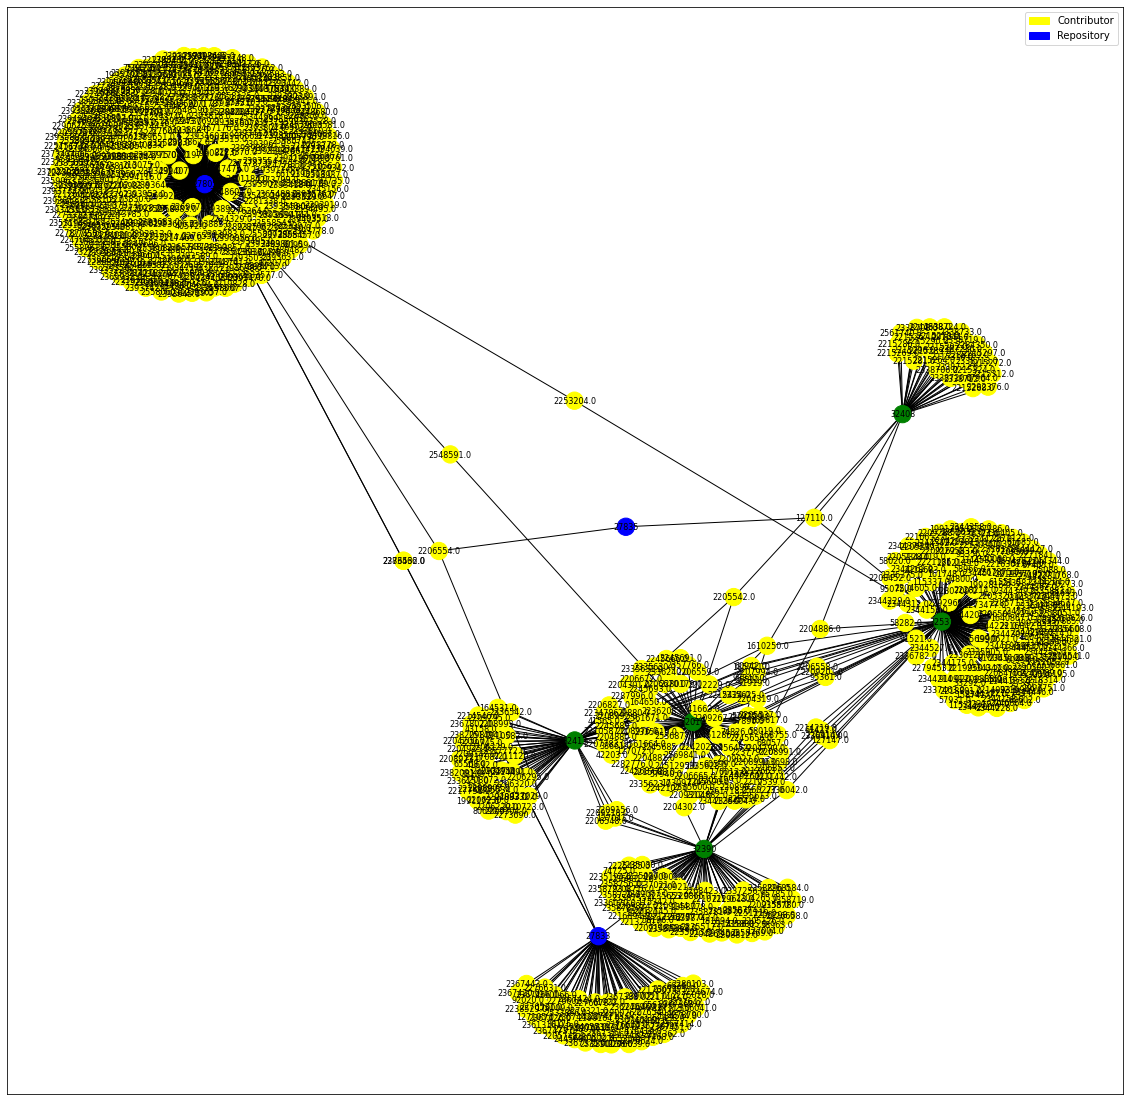

In [113]:
fig, ax = plt.subplots(figsize=(20,20))
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

### PR Contributor Graph

We now plot similar graphs as above for Pull Request type contributors

In [114]:
df_pr = pr_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
df_pr.head()

cntrb_id  25440    25447    25451    25458    25482    25483    25489    \
repo_id                                                                   
27805           0        0        0        0        0        0        0   
27825           0        0        0        0        0        0        0   
27833           0        0        0        0        0        0        0   
27835           2        0        0        0        0        0        0   
27850           0        0        0        0        0        0        0   

cntrb_id  25512    25516    25529    ...  2579015  2579016  2579017  2579018  \
repo_id                              ...                                       
27805           0        0        0  ...        4        1        1        1   
27825           0        0        0  ...        0        0        0        0   
27833           0        1        0  ...        0        0        0        0   
27835           0        0        3  ...        0        0        0        0   
27850           0        0        0  ...        0        0        0        0   

cntrb_id  2579019  2579020  2579313  2579372  2579379  2579407  
repo_id                                                         
27805           2        1        0        0        0        0  
27825           0        0        0        0        0        0  
27833           0        0        0        0        0        0  
27835           0        0        0        0        0        0  
27850           0        0        0        0        0        0  

[5 rows x 6596 columns]

In [115]:
df_pr = df_pr.reset_index()

In [116]:
df_melted_pr = df_pr.melt(
    ['repo_id'],
    var_name = 'cntrb_id',value_name='number')

In [117]:
df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]
df_melted_pr.head()

repo_id cntrb_id  number
3     27835    25440       2
18    32413    25447       1
28    32413    25451       2
38    32413    25458       2
45    32010    25482       1

In [118]:
Repo_id = df_melted_issue['repo_id'].to_list()
contributor_id = df_melted_issue['cntrb_id'].to_list()

In [119]:
G = nx.from_pandas_edgelist(df_melted_pr, 
                            source='repo_id',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [120]:
nodes = G.nodes()

In [121]:
colors = []
for n in nodes:
    if n in kubernetes_repos_ids:
        colors.append('blue')
    elif n in openshift_repos_ids:
        colors.append('green')
    else:
        colors.append('yellow')

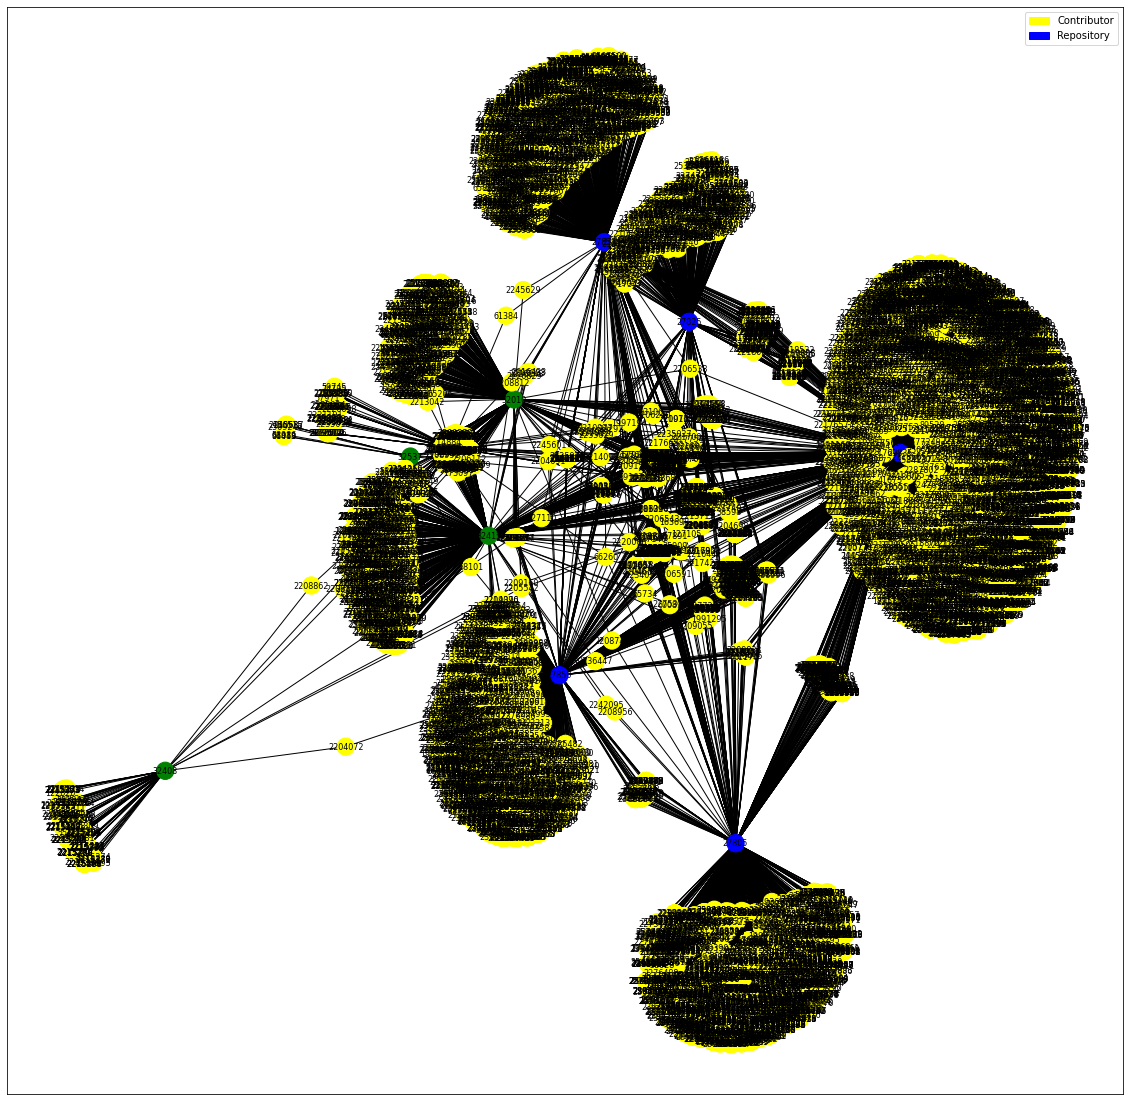

In [122]:
fig, ax = plt.subplots(figsize=(20,20))
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

## Nodes as projects edges as contributors

In this section, we represent data in a different way and try out another graph representation where the project repositories are represented by nodes and the edges are shared contributions between those projects

Lets pick the **Pull Request** type contribution for these graph plots as an example

In [130]:
df_melted_pr.head()

repo_id cntrb_id  number
3     27835    25440       2
18    32413    25447       1
28    32413    25451       2
38    32413    25458       2
45    32010    25482       1

In [131]:
contributorGraph = {}
for i, row in df_melted_pr.iterrows():
    if row['cntrb_id'] not in contributorGraph:
        contributorGraph[row['cntrb_id']] = []
    if(row['number'] > 0):
        contributorGraph[row['cntrb_id']].append((row['repo_id'], row['number']))

In [132]:
list(contributorGraph.items())[:10]

[(25440, [(27835, 2)]),
 (25447, [(32413, 1)]),
 (25451, [(32413, 2)]),
 (25458, [(32413, 2)]),
 (25482, [(32010, 1)]),
 (25483, [(32010, 1), (32413, 9)]),
 (25489, [(32413, 2)]),
 (25512, [(32010, 129), (32413, 38)]),
 (25516, [(27833, 1)]),
 (25529, [(27835, 3), (32010, 1)])]

`contributorGraph` above is a dictionary where each key is a project repository, and the value is a list of **"connected"** project repositories and the number of **"shared connections"** between them. Lets explain **"connected"** repositories and shared "connections".

structure of `contributorGraph` =  
{  
`repo1`: [(`repo2`, `PRs by same authors in repo 1 and repo 2`)],  
 `repo2`: [(`repo4`, `PRs created by same authors in repo 1 and repo 4` ), (`repo5`, `PRs by same authors in repo 2 and repo 5`)]  
}

**"shared connections"** constitute of *commits*, *pull requests*, *issues* and *pull request reviews* that are made by the same contributor.
We will call 2 project repositories **"connected"** if they have a **"shared connection"** between them. 
This means if they have a contributor who makes a *commit*, *pull request*, *issue* or *pull request review* in both the repositories, they count as a shared contributor and the repositories are connected. 

We track the number of shared contributions between 2 repositories for creating this graph plot.

In [133]:
commonRepoContributionsByContributor = collections.defaultdict(int)
for key in contributorGraph:
    if len(contributorGraph[key])-1 <= 0:
        continue
    for repoContributionIndex in range(len(contributorGraph[key])-1):
        commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])] += contributorGraph[key][repoContributionIndex][1]+contributorGraph[key][repoContributionIndex+1][1]
print(commonRepoContributionsByContributor)

defaultdict(<class 'int'>, {(32010, 32413): 8363, (27835, 32010): 4578, (27835, 32413): 2233, (27833, 27835): 44860, (27850, 32010): 137, (27825, 27850): 935, (27805, 27835): 1951, (27835, 27850): 36292, (27833, 27850): 199, (27805, 27833): 4252, (27850, 32413): 163, (27835, 32390): 63, (32390, 32413): 7912, (32413, 32537): 19383, (27805, 27850): 164, (27805, 27825): 12231, (27825, 27833): 17494, (27825, 27835): 884, (32010, 32390): 6811, (27833, 32390): 6, (27825, 32413): 2, (27850, 32390): 17, (27835, 32408): 758, (32408, 32413): 21296, (27833, 32413): 6, (27850, 32408): 2, (32390, 32408): 845, (32010, 32408): 67, (27805, 32413): 10, (27833, 32010): 35, (27805, 32390): 12})


`commonRepoContributionsByContributor` is a nested dictionary consisting of dictionaries of repository pairs and their common contributions. 

structure of `commonRepoContributionsByContributor` =  
{  
(`repo1, repo2`): `PRs by same authors in repo 1 and repo 2`,  
(`repo2, repo4`): `PRs by same authors in repo 2 and repo 4`,  
(`repo2, repo5`): `PRs by same authors in repo 2 and repo 5`,   
}

In [134]:
res = []
for key in commonRepoContributionsByContributor:
    res.append(tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],))

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [135]:
g = nx.Graph()
g.add_weighted_edges_from(res)

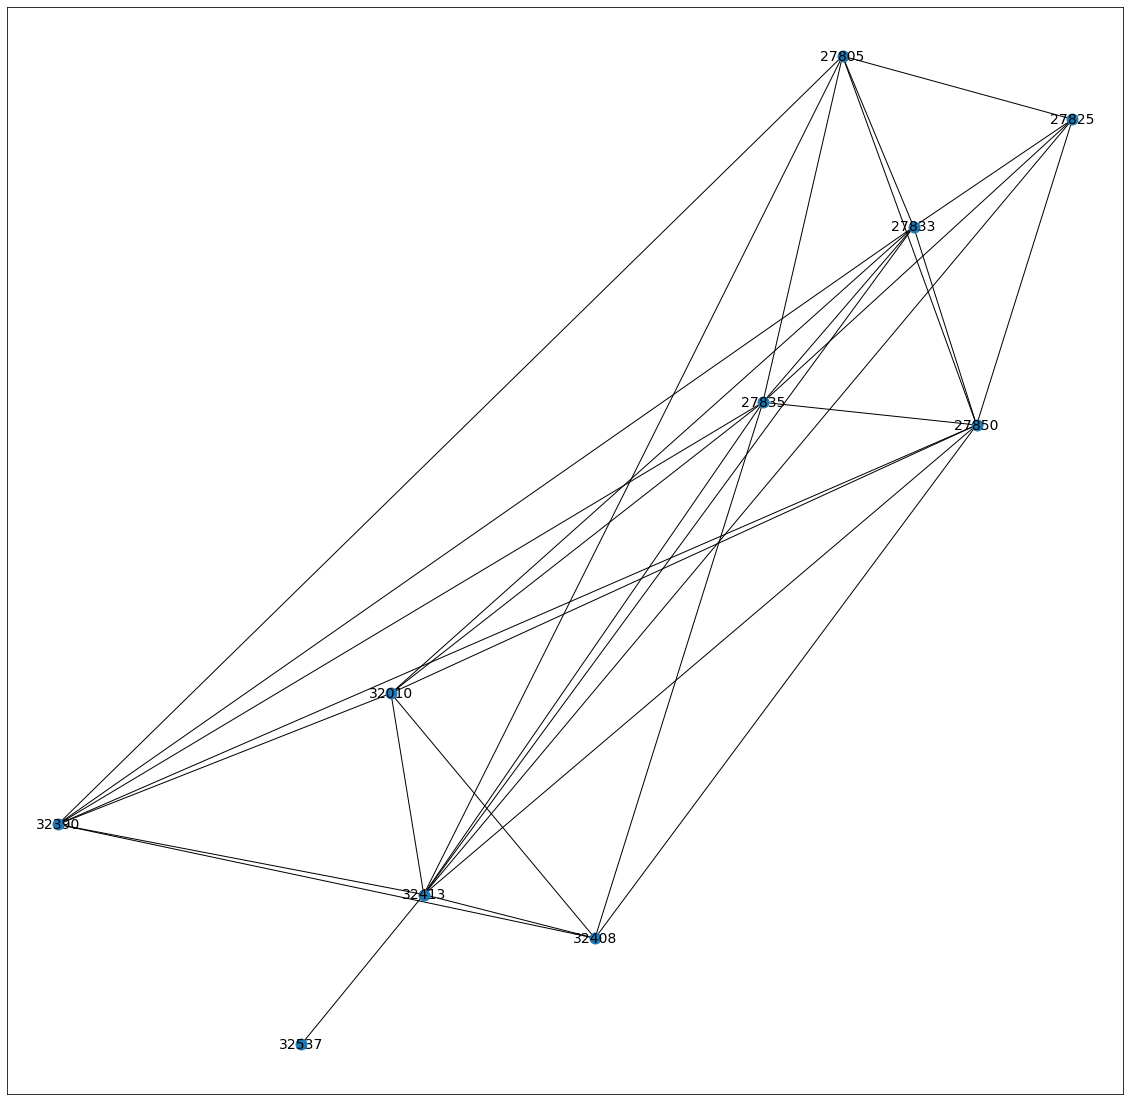

In [136]:
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx(g, node_size=120, font_size=14, ax=ax)


The above graph represents project repositories and how close or far they are to each other based on their degree of connected (number of shared contributions amongst them). If 2 nodes are close to each other, the 2 projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We are not plotting lone projects in this graph as we want to identify project repositories in connection to existing known repositories.  
Note: this is not a complete (fully-connected) graph. All projects are not **"connected"** to each project. See above for the definition of **"connected"** 

## Conclusion

In this notebook, we created initial graph representations of existing open source GitHub repositories falling under a certain category using [NetworkX](https://networkx.org/). 

We used 2 type of graph representations:

- One where repositories and contributors both are both nodes (differently colored). Viewing which repositories share which set of contributors and analyzing their clusters can give an idea about how projects are connected to each other and to what degree 
- One where repositories are nodes, and edges are number of contributions. The distance between repositories, how close or far they are will depend on the number of shared contributions that exist between them.